<h2> Malaria Detection Using Multilayer Perceptron</h2>

Import required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import tensorflow as tf
from sklearn.metrics import confusion_matrix, mean_squared_error,ConfusionMatrixDisplay
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import shap

<h2> Data Loading &  Data Preprocessing</h2>

- resize the images to a size of 50 by 50
- Assign labels

In [2]:
def read_images(path):
    images = []
    labels = []
    num1 = 50
    num2 = 50
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = plt.imread(file_path + '/' + img_name)
                    new_img = resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasitized':
                        label = 0
                    else:
                        label = 1
                    labels.append(label)
    
    return np.array(images), np.array(labels)

In [3]:
x, y= read_images('cell_images')

In [4]:
print("Image Dimension: ", x.shape)
print("Image Dimension: ", y.shape)

Image Dimension:  (27558, 50, 50, 3)
Image Dimension:  (27558,)


Parasitized


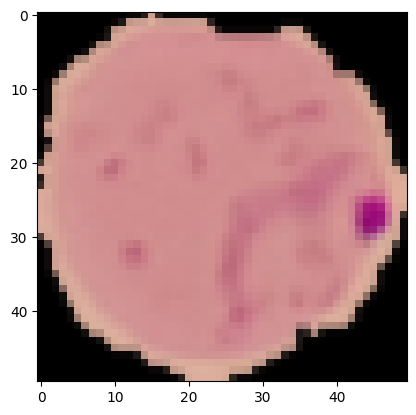

In [5]:
plt.imshow(x[88], cmap='gray')
if y[88]==1:
   print("Uninfected")
else:
    print("Parasitized") 

- Stacking and flattening the image data to a 2D array

In [6]:
def extract_and_flatten_features(images):
    return np.array([img.flatten() for img in images])

In [7]:
x_flattened = extract_and_flatten_features(x)

In [8]:
x_flattened[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

<h2>Feature Selection</h2>

- Filter Method: Mutual Information

In [9]:
mi_scores = mutual_info_classif(x_flattened, y)

# Select top k features based on mutual information scores
k = 10000  # Number of top features to select
selector = SelectKBest(mutual_info_classif, k=k)
X_selected = selector.fit_transform(x_flattened, y)

C:\Users\DWGBOB\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10000 is greater than n_features=7500. All the features will be returned.
  warnings.warn(


In [10]:
X_selected.shape

(27558, 7500)

- Wrapper Method: SelectFromModel with RandomForest and a mean threshold

In [11]:
#  Initialize SelectFromModel with the classifier and threshold
sfm = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='mean')

# Fit SelectFromModel to the selected features
x_final_selected = sfm.fit_transform(X_selected, y)

# Get support mask
support = sfm.get_support()

# Get indices of selected features
selected_indices = np.where(support)[0]
selected_features_sfm = X_selected[:, selected_indices]

In [12]:
selected_features_sfm.shape[1]

2030

2030 features are selected from the dataset after the feature selection process

- Standardization: scaling the images which transforms data to have a mean of 0 and a standard deviation of 1.

In [13]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(selected_features_sfm)
x_scaled.shape

(27558, 2030)

- Data Splitting: 80% training, 20% testing

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

In [15]:
x_train[0].shape

(2030,)

<h3>Model Development using Multi layer perceptron <h3>

In [50]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='sgd', max_iter=1000)

# Train the model
mlp.fit(x_train,y_train)

MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, solver='sgd')

- MLP Classifier evaluation

In [51]:
y_pred2 = mlp.predict(x_test)

# Evaluate the model
accur = accuracy_score(y_test,y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
mse_score = mean_squared_error(y_test, y_pred2)

# Print evaluation metrics
print("Multi Layer Perceptron")
print("Accuracy Score:", accur.__round__(2))
print("Precision Score:", precision.__round__(2))
print("Recall Score:", recall.__round__(2))
print("F1-score Score:", f1.__round__(2))
print("MSE Score:", mse_score)

Multi Layer Perceptron
Accuracy Score: 0.83
Precision Score: 0.82
Recall Score: 0.83
F1-score Score: 0.83
MSE Score: 0.17452830188679244


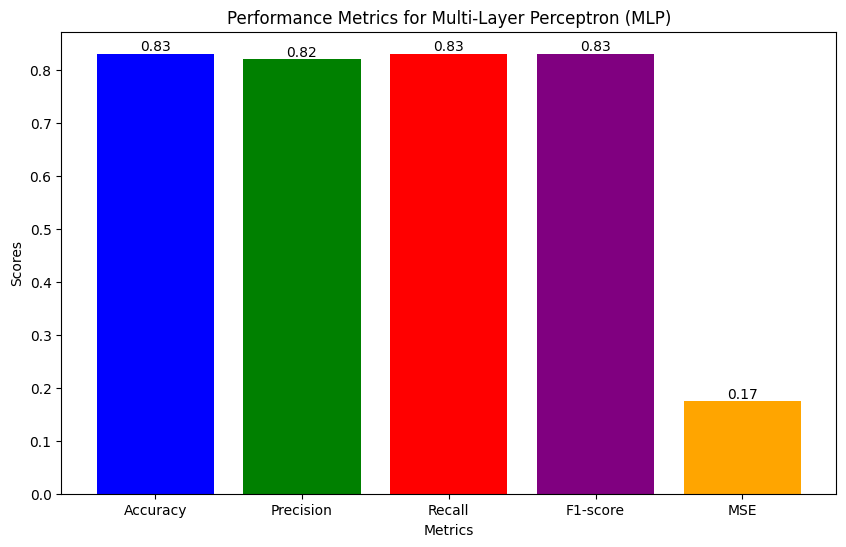

In [54]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'MSE']
scores = [0.83, 0.82, 0.83, 0.83, 0.1745]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=['blue', 'green', 'red', 'purple', 'orange'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Performance Metrics for Multi-Layer Perceptron (MLP)')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.show()

- Confusion Matrix

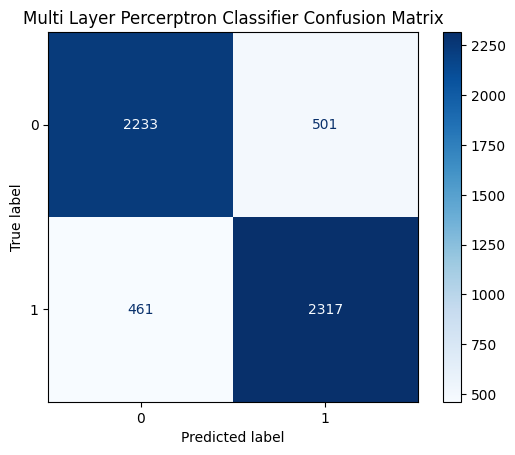

In [52]:
mlp_conf = confusion_matrix(y_test, y_pred2)

ConfusionMatrixDisplay(mlp_conf).plot(cmap='Blues')
plt.title("Multi Layer Percerptron Classifier Confusion Matrix")
plt.show()

MLP AUc-ROC

AUC-ROC: 0.8254026437212016


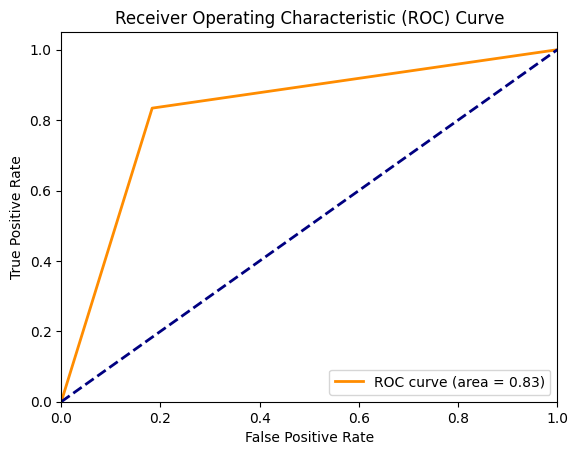

In [53]:
mlp_ypred_proba = mlp.predict(x_test).ravel()

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, mlp_ypred_proba)
print('AUC-ROC:', auc_roc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mlp_ypred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

- Make predictions

In [44]:
samp1 = mlp.predict([x_test[1000]])
if samp1[0]==1:
    print("Output: Paratisized")
else:
    print("Output: Uninfected")

Output: Paratisized


In [46]:
samp1 = mlp.predict([x_test[2000]])
if samp1[0]==1:
    print("Output: Paratisized")
else:
    print("Output: Uninfected")

Output: Uninfected


- Save the MLP model 

In [20]:
import joblib
joblib.dump(mlp, "mlp_malaria_model")

['mlp_malaria_model']

<h3> Explainable AI techniques using SHAP</h3>

- Create a SHAP explainer and calculate SHAP values

In [22]:
explainer = shap.KernelExplainer(mlp.predict, x_train[:100])  # Use a subset of data for the explainer

shap_values = explainer.shap_values(x_test[:10])  # Explain a subset of the test data

  0%|          | 0/10 [00:00<?, ?it/s]

- Visualize the SHAP values for the first prediction and summary plot to see the global feature importance

In [43]:
expected_value = float(explainer.expected_value)
shap_values_0 = shap_values[0].astype(float)
x_test_0 = x_test[0].astype(float)

shap.initjs()
shap.force_plot(expected_value, shap_values_0, x_test_0)

- Visualize the summary for the first 10 instances

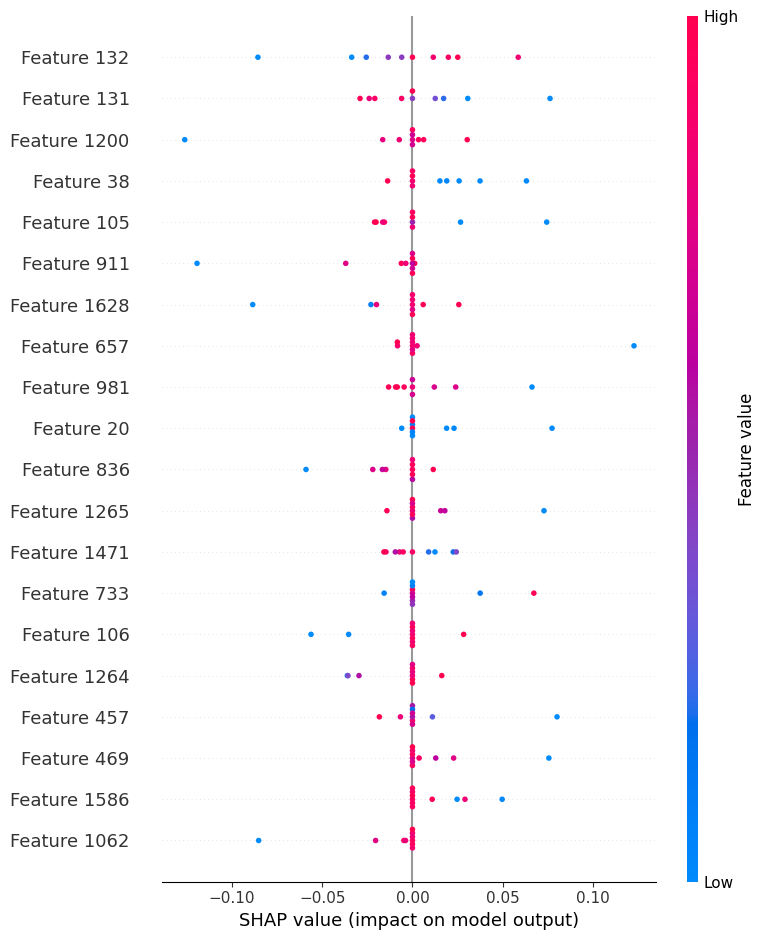

In [25]:
shap.summary_plot(shap_values[:10],x_test[:10])